# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [64]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here
import sympy as sym

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

As shown below, the analytic solution to the IVP $y' = y$ with $y(0) = 1$ is $y(t) = e^t$.

Aditionally, as shown below, the error in our `ForwardEuler` solver is significant, particularly for values of time greater than 1, where the red dashed line (`ForwardEuler`) breaks away from the white dotted line (the analytic solution). Meanwhile, the default `RK45` solver used by `solve_ivp` yields a solution with no visibily discernible error: the blue solid line (`RK45`) appears to lie directly below the white dotted line (the analytic solution).

Initial Value Problem:


/home/rewinter/STAT_37830/homework-3-rewinter799/euler.py:19: UserWarning: Warning: Extraneous arguments are irrelevant and will not be used.
  warn("Warning: Extraneous arguments are irrelevant and will not be used.")


Eq(Derivative(y(t), t), y(t))

Analytic Solution:


Eq(y(t), exp(t))

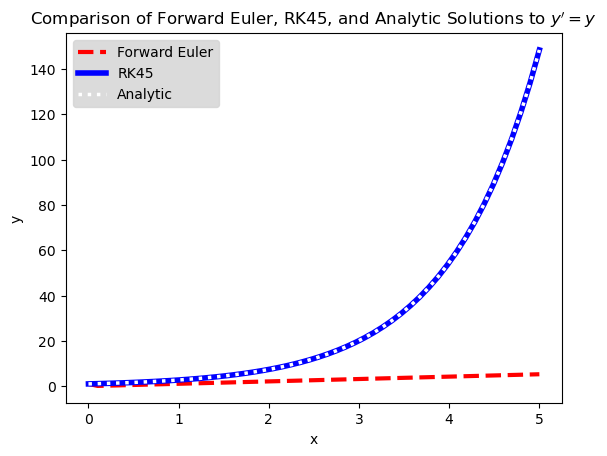

In [65]:
### Analysis
## Setup
f = lambda t, y : y
t_span = (0, 5)
y0 = np.array([1])
t_eval = np.linspace(0, 5, 50)

## ForwardEuler solution
fwd_euler_sol = solve_ivp(f, t_span, y0, method = ForwardEuler, t_eval = t_eval)

## Default Solver in `solve_ivp`
ivp_sol = solve_ivp(f, t_span, y0, t_eval = t_eval) # Default method is "RK45"

## Analytic solution
y = sym.symbols("y", cls=Function)
t = sym.symbols("t")
diffeq = sym.Eq(y(t).diff(t), y(t))
analytic_sol = dsolve(diffeq, ics = {y(0) : 1})
print("Initial Value Problem:")
display(diffeq)
print("Analytic Solution:")
display(analytic_sol)

### Plot
## Plot of the ForwardEuler solution.
plt.plot(fwd_euler_sol.t, fwd_euler_sol.y, c = "r", linewidth = 3, linestyle = "--", label = "Forward Euler")
## Plot of the solve_ivp solution.
plt.plot(ivp_sol.t, ivp_sol.y[0], c = "b", linewidth = 4, label = "RK45")
## Plot of the analytic solution, y = e^x, appears to perfectly coincide
## with the solve_ivp solution.
plt.plot(ivp_sol.t, np.exp(ivp_sol.t), c = "w", linewidth = 2.5, linestyle = ":", label = "Analytic")
## Labels, etc.
plt.xlabel(r'x')
plt.ylabel(r'y')
plt.title("Comparison of Forward Euler, RK45, and Analytic Solutions to " + r"$y' = y$")
plt.legend(loc = "upper left")
frame = plt.legend(frameon = 1).get_frame()
frame.set_color("lightgray")



### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\| \\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\| \\
x_1'(t) = p_1(t) \\
x_2'(t) = p_2(t)
\end{equation}

\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\| \\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\| \\
y_1'(t) = q_1(t) \\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

Our simulation of the moon's revolution around the earth can be viewed by running the code chunk below.

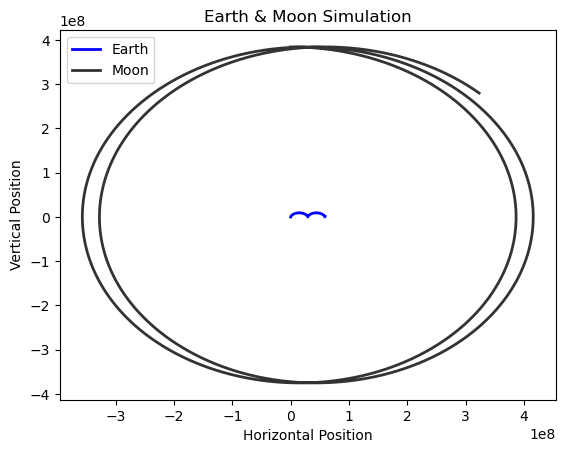

In [66]:
# Constants
G = 6.67e-11
m1 = 5.972e24
m2 = 0.07346e24
r = 384.4e6
Fg = G * m1 * m2 / (r**2)

# Vectors z have the form:
# (Earth position, earth speed, moon position, moon speed), or
# (x1, x2, p1, p2, y1, y2, q1, q2) 
def rhs(t, z):
    return np.array([z[2],                              #x1'(t)
                     z[3],                              #x2'(t)
                     -(Fg/m1) * ((z[0] - z[4])/r),      #p1'(t)
                     -(Fg/m1) * ((z[1] - z[5])/r),      #p2'(t)
                     z[6],                              #y1'(t)
                     z[7],                              #y2'(t)
                     (Fg/m2) * ((z[0] - z[4])/r),       #q1'(t)
                     (Fg/m2) * ((z[1] - z[5])/r)])      #q2'(t)

# Initial conditions
z0 = np.array([0, 0, 0, 0, 0, 384.4e6, 1.022e3, 0])

t_span = (0, 5e6)
t_eval = np.linspace(0, 5e6, int(5e6))

sim = solve_ivp(rhs, t_span, z0, t_eval = t_eval)

# Plot
plt.plot(sim.y[0], sim.y[1], label = "Earth", c = "b", linewidth = 2)
plt.plot(sim.y[4], sim.y[5], label = "Moon", c = "0.2", linewidth = 2)
plt.xlabel("Horizontal Position")
plt.ylabel("Vertical Position")
plt.title("Earth & Moon Simulation")
plt.legend(loc = "best")

### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

Our simulation of ten planets with randomly generated masses, initial positions, and initial velocities can be viewed by running the code chunk below.

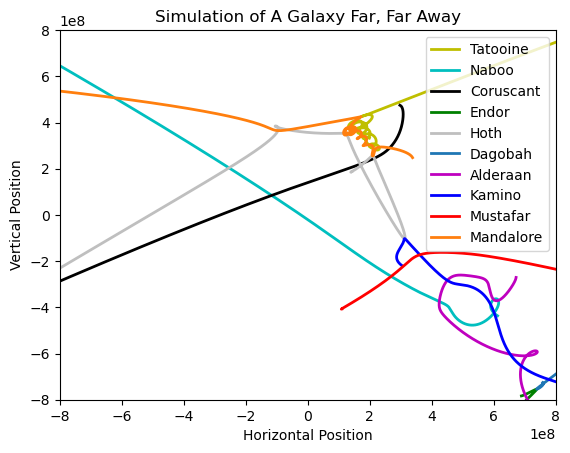

In [67]:
import random as rand

# Random initial conditions
planets = np.zeros((10, 5))
for i in range(10):
    # Random masses
    planets[i, 0] = rand.uniform(0, 6e24)
    # Random initial coordinates
    planets[i, 1] = rand.uniform(-8e8, 8e8)
    planets[i, 2] = rand.uniform(-8e8, 8e8)
    # Random initial velocities
    planets[i, 3] = rand.uniform(-5e2, 5e2)
    planets[i, 4] = rand.uniform(-5e2, 5e2)

G = 6.67e-11 # Gravitational constant

# Vectors z have the form:
# (Planet 1 position, Planet 1 speed, ..., Planet 10 position, Planet 10 speed), or
# (x1.1, x1.2, p1.1, p1.2, ..., x10.1, x10.2, p10.1, p10.2)
def rhs(t, z):
    eqns = np.zeros(10*4)
    for i in range(10):                         # For each Planet i for i = 0, ..., 9:
        mi = planets[i, 0]                      # the mass of Planet i

        for j in range(10):
            if i != j:                          # Examine the nine planet pairs (i, j) for j != i
                mj = planets[j, 0]              # the mass of Planet j

                r1 = z[4*i + 0] - z[4*j + 0]    # the horizontal dist b/w Planets i and j
                r2 = z[4*i + 1] - z[4*j + 1]    # the vertical dist b/w Planets i and j
                r = np.sqrt(r1**2 + r2**2)      # the Euclidean dist b/w Planets i and j

                Fg = G * mi * mj / (r**2)       # the force of gravity b/w Planets i and j

                accel1 = -Fg / mi * r1/r        # pi.1'(t)
                eqns[4*i + 2] += accel1

                accel2 = -Fg / mi * r2/r        # pi.2'(t)
                eqns[4*i + 3] += accel2

        eqns[4*i + 0] = z[4*i + 2]              # xi.1'(t)
        eqns[4*i + 1] = z[4*i + 3]              # xi.2'(t)
    
    return(eqns)

# Reorganize the initial conditions into a vector
z0 = np.zeros(10*4)
for i in range(10):
    z0[4*i + 0] = planets[i, 1]
    z0[4*i + 1] = planets[i, 2]
    z0[4*i + 2] = planets[i, 3]
    z0[4*i + 3] = planets[i, 4]

t_span = (0, 5e6)
t_eval = np.linspace(0, 5e6, int(5e6))

sim2 = solve_ivp(rhs, t_span, z0, t_eval = t_eval)

# Plot

plt.plot(sim2.y[0], sim2.y[1], label = "Tatooine", linewidth = 2, c = "y")
plt.plot(sim2.y[4], sim2.y[5], label = "Naboo", linewidth = 2, c = "c")
plt.plot(sim2.y[8], sim2.y[9], label = "Coruscant", linewidth = 2, c = "k")
plt.plot(sim2.y[12], sim2.y[13], label = "Endor", linewidth = 2, c = "g")
plt.plot(sim2.y[16], sim2.y[17], label = "Hoth", linewidth = 2, c = "0.75")
plt.plot(sim2.y[20], sim2.y[21], label = "Dagobah", linewidth = 2)
plt.plot(sim2.y[24], sim2.y[25], label = "Alderaan", linewidth = 2, c = "m")
plt.plot(sim2.y[28], sim2.y[29], label = "Kamino", linewidth = 2, c = "b")
plt.plot(sim2.y[32], sim2.y[33], label = "Mustafar", linewidth = 2, c = "r")
plt.plot(sim2.y[36], sim2.y[37], label = "Mandalore", linewidth = 2)

ax = plt.gca()
ax.set_xlim([-8e8, 8e8])
ax.set_ylim([-8e8, 8e8])
plt.xlabel("Horizontal Position")
plt.ylabel("Vertical Position")
plt.title("Simulation of A Galaxy Far, Far Away")
plt.legend(loc = "best")

## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

------

As shown below our simulation results are highly accurate, with a sum of squared errors for $t = 0$ of roughly `3.1e-6` and a sum of squared errors for $t = T$ of roughly `2.9e-9`. Our visualization below underscores this accuracy, with plots of the analytic solutions for t = 0 and t = T lying directly above the respective simulation results.

Sum of Squared Errors for t = 0: 3.130733555482495e-06
Sum of Squared Errors for t = T: 2.8626820783229703e-09


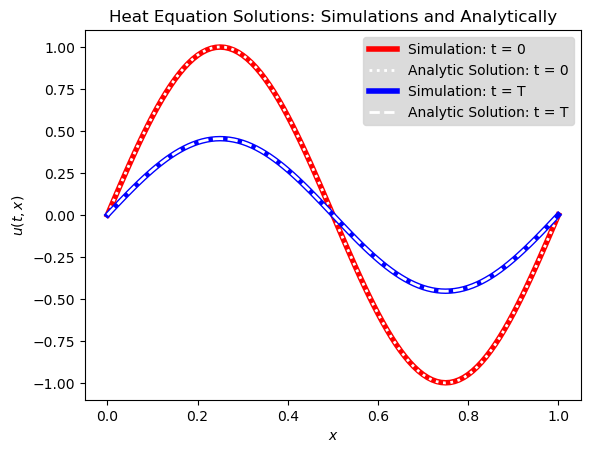

In [61]:

# Functions
def second_diff(u,dx):
    """
    Parameter u is a vector representing the current state of the system.
    Parameter dx is the grid spacing / standard distance between x-values.

    Returns laplacian, an approximation of the Laplacian operator using the second order centered difference formula on u.
    """
    laplacian = np.zeros(len(u))                                # Initialize empty Laplacian
    for i in range(1, len(u)-1):                                # Keep first and last elements 0
        laplacian[i] = (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)     # Set second derivative at interior nodes using centered diff formula
    return laplacian

def time_step(u,dx,dt):
    """
    Parameter u is a vector.
    Parameter dx is the grid spacing / standard distance between x-values.
    Parameter dt is the time step to be used in evaluation of the system of differential equations.

    Returns u_new, a vector representing the new state of the system after implementing the Forward Euler method.
    """
    u_new = np.zeros(len(u))                    # Initialize empty new state
    laplacian = second_diff(u, dx)              # Compute Laplacian of current state
    for i in range(len(u)):                     # Ignore zeroth value, since using Forward Euler
        u_new[i] = u[i] + dt * laplacian[i]     # Compute next state using Forward Euler
    return u_new
    
def sim_heat(n,f,bc,dx,dt,T):
    """
    Parameter n is the number of internal nodes in the discretization of the unit interval.
    Parameter f is a function giving the system's initial condition.
    Parameter bc is an ndarray containing the left and right boundary conditions of the system.
    Parameter dx is the grid spacing / standard distance between x-values.
    Parameter dt is the time step to be used in evaluation of the system of differential equations.
    Parameter T is the time at which the solution to the system of differential equations will be computed.

    Returns u, the state of the system at time T.
    """

    u = np.zeros(n + 2)                             # u has 99 internal nodes + 2 boundary nodes
    u[0], u[-1] = bc[0], bc[1]                      # Define boundary notes based on boundary conditions
    for i in range(1, n+1):                         # Compute internal nodes by applying f to regularly-sized steps
        u[i] = f(i*dx)

    num_steps = int(T // dt)
    for i in range(num_steps - 1):                  # All but the last time steps are of size dt
        u = time_step(u, dx, dt)
    u = time_step(u, dx, T - dt*(num_steps - 1))    # Final time step to get to T is smaller than dt
    return u

# Simulation Parameters
n = 99
f = lambda x : np.sin(2 * np.pi * x)
bc = np.array([0, 0])
dx = 1 / (n + 1)
dt = 0.2 * dx**2
T = 0.02

# Simulations
sim_0 = sim_heat(n, f, bc, dx, dt, 0)
sim_T = sim_heat(n, f, bc, dx, dt, T)

# Analytic Solution
analytic_sol = lambda t, x : np.exp(-4 * np.pi**2 * t) * np.sin(2 * np.pi * x)

# Visualization
xs = np.linspace(0, 1, 101)

plt.plot(xs, sim_0, c = "r", linewidth = 4, label = "Simulation: t = 0")                        # Plot of u(0, x)
plt.plot(xs, analytic_sol(0, xs), c = "w", linewidth = 2, label = "Analytic Solution: t = 0", linestyle = ":")   # Analytic solution for t = 0

plt.plot(xs, sim_T, c = "b", linewidth = 4, label = "Simulation: t = T")                        # Plot of u(T, x)
plt.plot(xs, analytic_sol(T, xs), c = "w", linewidth = 2, label = "Analytic Solution: t = T", linestyle = "--")   # Analytic solution for t = 0

plt.title("Heat Equation Solutions: Simulations and Analytically")
plt.xlabel(r'$x$')
plt.ylabel(r'$u(t, x)$')

frame = plt.legend(frameon = 1).get_frame()
frame.set_color("lightgray")

# Errors
errors_0 = sum((sim_0 - analytic_sol(0, xs))**2) / np.sqrt(n)
print("Sum of Squared Errors for t = 0:", errors_0)

errors_T = sum((sim_T - analytic_sol(T, xs))**2) / np.sqrt(n)
print("Sum of Squared Errors for t = T:", errors_T)

## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

----------

As shown below, with a larger CFL number, our numerical solution of the heat equation for $t = T$ explodes, with a sum of squared errors (compared to the analytic solution) of roughly `1.6e114`! Meanwhile, our simulation for $t = 0$ remains accurate, with a sum of squared errors of only about `3.8e-5`. Indeed, if we were to zoom in on the figure below, we would observe that our red plot for $t = 0$ still has the approximate shape of $\sin(2\pi x)$ that we observed in Part (A). 

Sum of Squared Errors for t = 0: 3.8351486054661545e-05
Sum of Squared Errors for t = T: 1.5725916898606513e+114


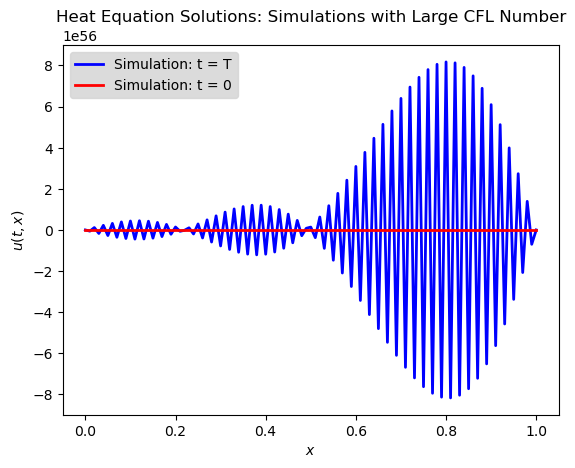

In [62]:
# Simulation Parameters
n = 99
f = lambda x : np.sin(2 * np.pi * x)
bc = np.array([0, 0])
dx = 1 / (n + 1)
dt = 0.7 * dx**2
T = 0.02

# Simulations
sim_0 = sim_heat(n, f, bc, dx, dt, 0)
sim_T = sim_heat(n, f, bc, dx, dt, T)

# Analytic Solution
analytic_sol = lambda t, x : np.exp(-4 * np.pi**2 * t) * np.sin(2 * np.pi * x)

# Visualization
xs = np.linspace(0, 1, 101)

plt.plot(xs, sim_T, c = "b", linewidth = 2, label = "Simulation: t = T")                        # Plot of u(T, x)
#plt.plot(xs, analytic_sol(T, xs), c = "w", linewidth = 2, label = "Analytic Solution: t = T", linestyle = "--")   # Analytic solution for t = 0

plt.plot(xs, sim_0, c = "r", linewidth = 2, label = "Simulation: t = 0")                        # Plot of u(0, x)
#plt.plot(xs, analytic_sol(0, xs), c = "w", linewidth = 2, label = "Analytic Solution: t = 0", linestyle = ":")   # Analytic solution for t = 0

plt.title("Heat Equation Solutions: Simulations with Large CFL Number")
plt.xlabel(r'$x$')
plt.ylabel(r'$u(t, x)$')

frame = plt.legend(frameon = 1).get_frame()
frame.set_color("lightgray")

# ax = plt.gca()
# ax.set_ylim([-2, 2])

#Errors
errors_0 = sum((sim_0 - analytic_sol(0, xs))**2) / np.sqrt(n)
print("Sum of Squared Errors for t = 0:", errors_0)

errors_T = sum((sim_T - analytic_sol(T, xs))**2) / np.sqrt(n)
print("Sum of Squared Errors for t = T:", errors_T)

## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.